# Image classification

### Descripción
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


### Objetivo
Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:
  1. Modelo con capas densas.

  2. Modelo con capas convolucionales y densas.

  3. Modelo que incluya bloques residuales identidad:

  4. Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications


Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

## 1. Configurar entorno de trabajo

### 1.1. Instalar librerías necesarias

In [1]:
!pip install -q gdown
!pip install Pillow

### 1.2. Importar las librerías necesarias

In [2]:
# Imports para manejo de archivos y directorios
import os
from pathlib import Path
import zipfile
import warnings
warnings.filterwarnings("ignore")

# Librerías para procesamiento de imágenes
import cv2
from PIL import Image
from skimage import io

# Librerías para manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para aprendizaje automático y redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Activation, GlobalMaxPooling2D
from tensorflow.keras import regularizers

# Librerías específicas para procesamiento de imágenes con keras
from keras.preprocessing.image import img_to_array
from keras.layers import RandomFlip, RandomContrast, RandomTranslation, Rescaling
from keras.layers import Activation, GlobalMaxPooling2D

# Librerías específicas para procesamiento de datos con sklearn
from sklearn.feature_extraction import image
from sklearn.preprocessing import LabelEncoder

# Librerías para descargas y manipulación de archivos en la nube
import gdown
import random

### 1.3 - Descargar y extraer el dataset

In [3]:
# Descargar el dataset
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

# Extraerlo
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=bbeb08f7-48e5-4505-b294-4c2e9ee983a2
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:05<00:00, 67.5MB/s]


### 1.4. Establecer GPU por defecto en caso de estar disponible.

In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## 2. Análisis Exploratorio de los Datos (EDA)

Se comenzará haciendo un análisis explotarorio del dataset para conocer sus características principales y evaluar si es necesario hacer algún proceso antes de comenzar.

### Dataset

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street

Las imágenes están divididas en tres conjuntos:

- Train: Alrededor de 14,000 imágenes para entrenamiento.

- Test: Alrededor de 3,000 imágenes para evaluación del modelo.

- Prediction: Alrededor de 7,000 imágenes para predicción final.

### 2.1. Definir directorios del dataset

In [5]:
# Definir el directorio dónde se encuentra el dataset
dataset_dir = "/content/TP1-3"

# Definir los directorios de train y test
train_dir = os.path.join(dataset_dir, "seg_train", "seg_train")
test_dir = os.path.join(dataset_dir, "seg_test", "seg_test")

### 2.2. Generadores de datos y aumentadores

In [6]:
# Aumentadores y generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Escalar los valores de píxel al rango [0,1]
    shear_range=0.2,  # Rango de deformación por cizallamiento
    zoom_range=0.2,  # Rango de aumento de zoom
    horizontal_flip=True,  # Girar aleatoriamente las imágenes horizontalmente
    validation_split=0.2  # Separar los datos de entrenamiento en 80% para training y 20% para validación
)

# Generador de datos para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Directorio de entrenamiento
    target_size=(96, 96),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    subset='training'  # Especificar que este es el conjunto de entrenamiento
)

# Generador de datos para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Directorio de entrenamiento
    target_size=(96, 96),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    subset='validation'  # Especificar que este es el conjunto de validación
)

# Preprocesar los datos de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de datos para el conjunto de pruebas
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Directorio de pruebas
    target_size=(96, 96),  # Tamaño de las imágenes objetivo
    batch_size=32,  # Tamaño del lote
    class_mode='categorical',  # Modo de clasificación categórica
    shuffle=False  # Mantener el orden para la evaluación
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### 2.3. Análisis del dataset

In [ ]:
# Función para cargar y mostrar una imagen
def show_image(image_path):
    # Lee la imagen utilizando OpenCV
    image = cv2.imread(str(image_path))
    # Obtiene la etiqueta de la imagen (nombre de la carpeta que la contiene)
    label = image_path.parent.name
    # Muestra la imagen utilizando matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Desactiva los ejes del gráfico
    plt.axis('off')
    # Establece el título del gráfico con la clase de la imagen
    plt.title(f'Imagen de ejemplo para la clase: {label}')
    # Muestra la imagen
    plt.show()

# Función para verificar el tamaño de las imágenes
def check_image_sizes(image_dir):
    # Conjunto para almacenar tamaños únicos de imágenes
    image_sizes = set()
    # Itera sobre los archivos en el directorio de imágenes
    for filename in os.listdir(image_dir):
        # Construye la ruta completa de la imagen
        image_path = os.path.join(image_dir, filename)
        # Lee la imagen utilizando OpenCV
        image = cv2.imread(image_path)
        # Obtiene la altura y el ancho de la imagen
        height, width, _ = image.shape
        # Agrega el tamaño al conjunto de tamaños de imagen
        image_sizes.add((height, width))
    return image_sizes

# Función para verificar el formato de las imágenes
def check_image_formats(image_dir):
    # Conjunto para almacenar formatos únicos de imágenes
    image_formats = set()
    # Itera sobre los archivos en el directorio de imágenes
    for filename in os.listdir(image_dir):
        # Construye la ruta completa de la imagen
        image_path = os.path.join(image_dir, filename)
        # Lee la imagen utilizando OpenCV
        image = cv2.imread(image_path)
        # Agrega el formato de color al conjunto de formatos de imagen
        image_formats.add(image.shape[2])  # 2 para obtener el número de canales de color
    return image_formats

# Función para verificar el balance de clases
def check_class_balance(image_dir):
    # Diccionario para almacenar el recuento de imágenes por clase
    class_counts = {}
    # Itera sobre las carpetas de clases en el directorio de imágenes
    for class_name in os.listdir(image_dir):
        # Construye la ruta completa de la carpeta de la clase
        class_path = os.path.join(image_dir, class_name)
        # Cuenta el número de imágenes en la clase y lo almacena en el diccionario
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts


Clase: buildings
Tamaños de imágenes encontrados: {(124, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


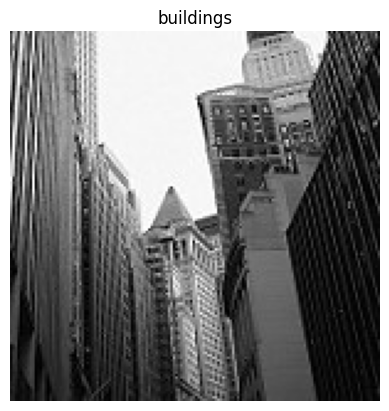

----------------------------------------------------


Clase: forest
Tamaños de imágenes encontrados: {(115, 150), (113, 150), (108, 150), (133, 150), (150, 150), (135, 150), (136, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


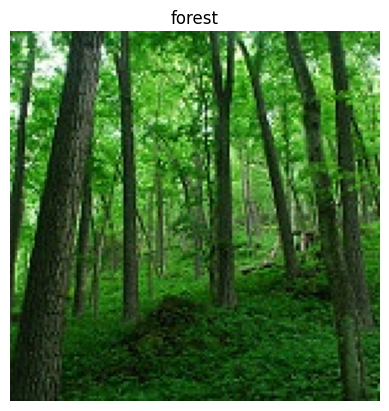

----------------------------------------------------


Clase: glacier
Tamaños de imágenes encontrados: {(143, 150), (146, 150), (97, 150), (120, 150), (134, 150), (142, 150), (105, 150), (111, 150), (149, 150), (150, 150), (123, 150), (102, 150), (135, 150), (119, 150), (76, 150), (110, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


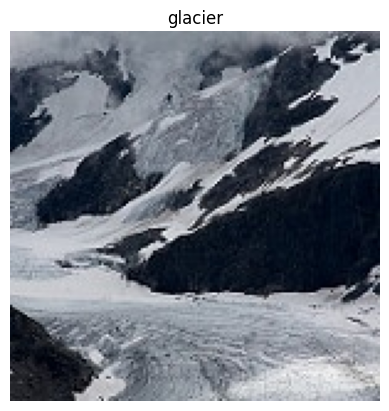

----------------------------------------------------


Clase: mountain
Tamaños de imágenes encontrados: {(143, 150), (141, 150), (146, 150), (134, 150), (142, 150), (113, 150), (100, 150), (147, 150), (144, 150), (150, 150), (145, 150), (123, 150), (135, 150), (81, 150), (103, 150), (136, 150), (131, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


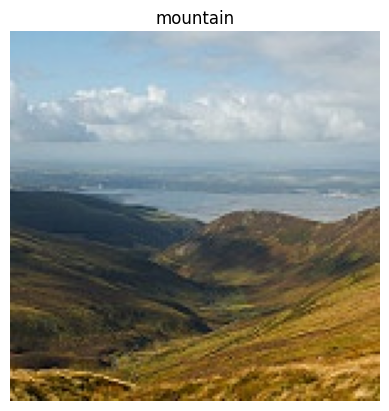

----------------------------------------------------


Clase: sea
Tamaños de imágenes encontrados: {(140, 150), (113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


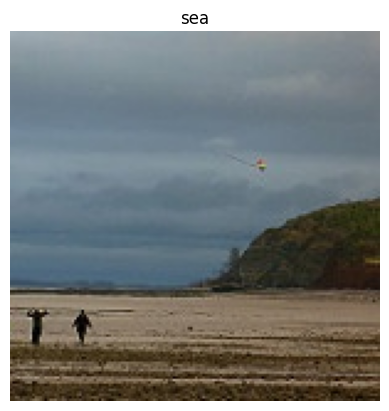

----------------------------------------------------


Clase: street
Tamaños de imágenes encontrados: {(113, 150), (150, 150)}
Formatos de imágenes encontrados. Número de canales de color: {3}


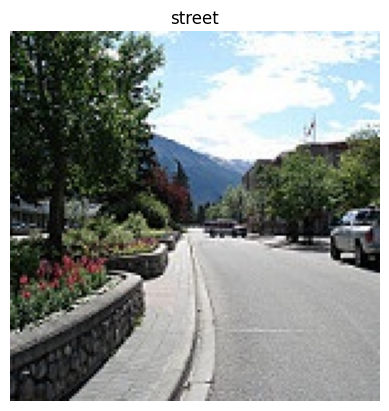

----------------------------------------------------




In [ ]:
# Función para cargar y mostrar una imagen
def show_image(image_path):
    # Lee la imagen utilizando OpenCV
    image = cv2.imread(image_path)
    # Obtiene la etiqueta de la imagen (nombre de la carpeta padre)
    label = os.path.basename(os.path.dirname(image_path))  # Obtener el nombre del directorio padre
    # Muestra la imagen utilizando matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Establece el título del gráfico con la etiqueta de la clase
    plt.title(label)
    # Desactiva los ejes del gráfico
    plt.axis('off')
    # Muestra la imagen
    plt.show()

# Obtiene los nombres de las clases
class_names = list(train_generator.class_indices.keys())

# Itera sobre las clases
for image_class in class_names:
    # Imprime el nombre de la clase
    print(f'Clase: {image_class}')
    # Construye la ruta del directorio de imágenes para la clase actual
    image_directory = os.path.join(train_dir, image_class)  # Ajusta la ruta según train_dir

    # Verifica el tamaño de las imágenes en el directorio
    image_sizes = check_image_sizes(image_directory)
    print("Tamaños de imágenes encontrados:", image_sizes)

    # Verifica el formato de las imágenes en el directorio
    image_formats = check_image_formats(image_directory)
    print("Formatos de imágenes encontrados. Número de canales de color:", image_formats)

    # Obtiene la lista de rutas de imágenes de prueba
    test_image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith('.jpg')]
    # Selecciona aleatoriamente una imagen de la lista para mostrar
    sample_image_path = random.choice(test_image_paths)
    # Muestra la imagen
    show_image(sample_image_path)

    print('----------------------------------------------------')
    print('\n')



In [ ]:
# Verificar balance de clases
class_balance = check_class_balance(train_dir)
print("Balance de clases:", class_balance)

Balance de clases: {'mountain': 2512, 'glacier': 2404, 'street': 2382, 'forest': 2271, 'buildings': 2191, 'sea': 2274}


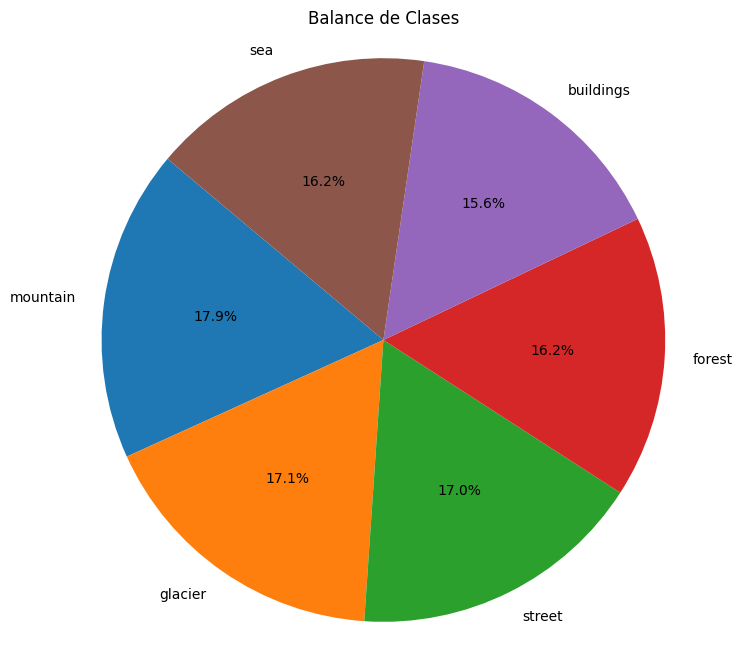

In [ ]:
# Extraer nombres de clases y sus respectivos valores
class_names = list(class_balance.keys())
class_counts = list(class_balance.values())

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Balance de Clases')
plt.axis('equal')  # Hace que el gráfico de torta sea circular
plt.show()

Se observa que las calses están aceptablemente balanceadas. No se determinó que se necesite un balanceo.

### 2.4 - Visualización de imágenes de ejemplo

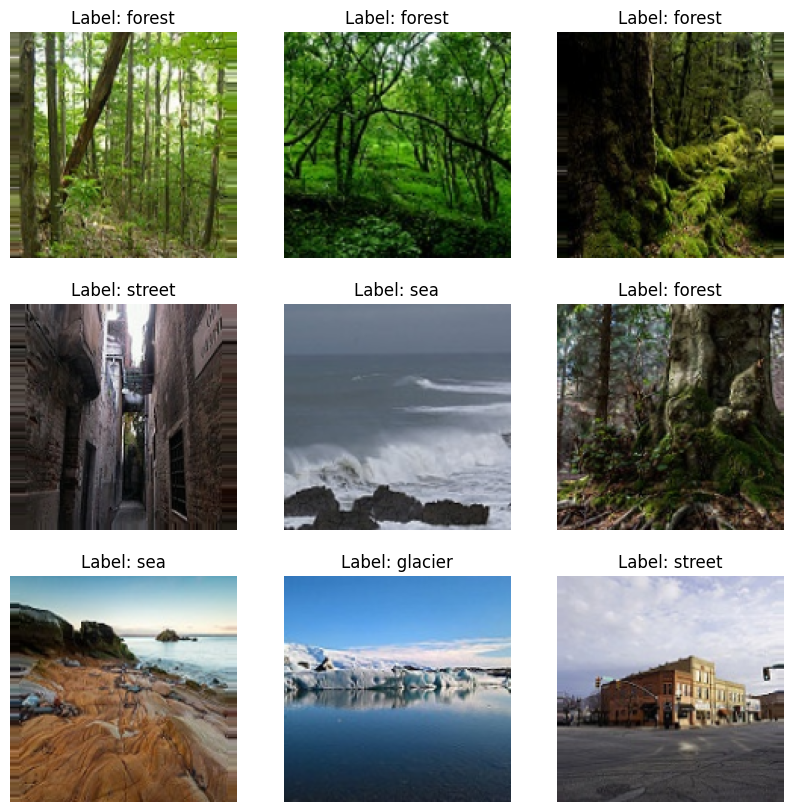

In [ ]:
# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Mostrar algunas imagenes de ejemplo del traing set con etiquetas
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    label_index = sample_labels[i].argmax()
    plt.title(f'Label: {class_labels[label_index]}')
    plt.axis("off")
plt.show()

## 3. Arquitecturas de Red

### 3.1 - Redes densas

El modelo es una red neuronal densa (fully connected) con 7 capas ocultas, cada una con 128 neuronas. La entrada de la red tiene un tamaño de (96, 96, 3), lo que significa que espera imágenes de tamaño 96x96 píxeles con 3 canales de color (RGB).

El preprocesamiento de las imágenes incluye normalización de los valores de píxeles (rescaling) para que estén en el rango [0, 1], así como aumentación de datos mediante operaciones como volteo horizontal y vertical, desplazamiento aleatorio y ajuste de contraste.

Después del preprocesamiento, las imágenes se aplanan y se pasan a través de 7 capas ocultas con activación ReLU (Rectified Linear Unit). Esta función de activación fue elegida por su no-linealidad, lo que le permite al modelo aprender patrones más complejos, por evitar el problema de la desaparición del gradiente y por su eficiencia computacional. Se utiliza, además, una capa de dropout con una tasa del 20% para regularizar el modelo y evitar el sobreajuste.

Finalmente, la red tiene una capa de salida con una activación softmax, idónea para la clasificación multiclase, y cuya salida es la probabilidad de pertenencia a la clase en cuestión. El modelo se compila con el optimizador Adam (Adaptive Moment Estimation) conocido por su rapidez en la convergencia y su capacidad para trabajar bien en una amplia gama de aplicaciones. La función de pérdida es entropía cruzada categórica (categorical_crossentropy) función de pérdida comúnmente utilizada en problemas de clasificación multiclase debido a su capacidad para penalizar las predicciones incorrectas y promover la confianza en la predicción correcta. La métrica de evaluación se establece en precisión (accuracy).

#### 3.1.1. Definición del modelo

In [ ]:
# Función para construir el modelo de clasificación
def build_classification_model(num_layers, num_neurons, input_shape):
    # Definición de la capa de entrada
    i = Input(input_shape, dtype=tf.float32)

    # Normalización de valores de píxeles
    x = Rescaling(1./255)(i)

    # Data augmentation
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Creación del modelo secuencial
    model = keras.Sequential()

    # Aplana las imágenes antes de la capa densa
    model.add(Flatten(input_shape=input_shape))

    # Añade la cantidad especificada de capas ocultas al modelo
    for _ in range(num_layers):
        model.add(Dense(num_neurons, activation='relu'))  # Capas ocultas

    # Añade una capa de dropout para reducir el overfitting
    model.add(keras.layers.Dropout(0.2))

    # Capa de salida con activación softmax para clasificación multiclase con 6 clases
    model.add(Dense(6, activation='softmax'))

    # Compila el modelo con:
    # - Optimizador: Adam
    # - Función de pérdida: Categorical Cross-Entropy
    # - Métrica adiciónal a mostrar: Accuracy
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### 3.1.2. Construir el modelo

In [ ]:
# Tamaño de las imágenes de entrada
input_shape = (96, 96, 3)

# Número de capas en la red neuronal
num_layers = 7

# Número de neuronas en cada capa oculta
num_neurons = 128

# Construir el modelo de clasificación
model_dnn = build_classification_model(num_layers, num_neurons, input_shape)


#### 3.1.3. Resumen del modelo

In [ ]:
# Mostrar un resumen del modelo
model_dnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 27648)             0         
                                                                 
 dense_28 (Dense)            (None, 128)               3539072   
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 128)              

#### 3.1.4. Se entrena el modelo

In [ ]:
# Entrenar el modelo
history_dnn = model_dnn.fit(
    train_generator,  # Generador de datos de entrenamiento
    validation_data=validation_generator,  # Generador de datos de validación
    epochs=20,  # Número de épocas de entrenamiento
    verbose=1  # Modo verbose (imprime información durante el entrenamiento)
)

Epoch 1/20
351/351 [==============================] - 47s 121ms/step - loss: 1.5177 - accuracy: 0.3826 - val_loss: 1.3619 - val_accuracy: 0.4636
Epoch 2/20
351/351 [==============================] - 43s 123ms/step - loss: 1.3571 - accuracy: 0.4744 - val_loss: 1.2769 - val_accuracy: 0.4943
Epoch 3/20
351/351 [==============================] - 40s 113ms/step - loss: 1.2880 - accuracy: 0.4988 - val_loss: 1.2172 - val_accuracy: 0.5467
Epoch 4/20
351/351 [==============================] - 41s 116ms/step - loss: 1.2297 - accuracy: 0.5256 - val_loss: 1.2240 - val_accuracy: 0.5396
Epoch 5/20
351/351 [==============================] - 41s 116ms/step - loss: 1.2015 - accuracy: 0.5336 - val_loss: 1.1586 - val_accuracy: 0.5528
Epoch 6/20
351/351 [==============================] - 40s 113ms/step - loss: 1.1778 - accuracy: 0.5465 - val_loss: 1.1604 - val_accuracy: 0.5442
Epoch 7/20
351/351 [==============================] - 42s 119ms/step - loss: 1.1487 - accuracy: 0.5610 - val_loss: 1.1176 - val_ac

#### 3.1.5. Graficar el Acuracy y el Loss de entrenamiento y validación

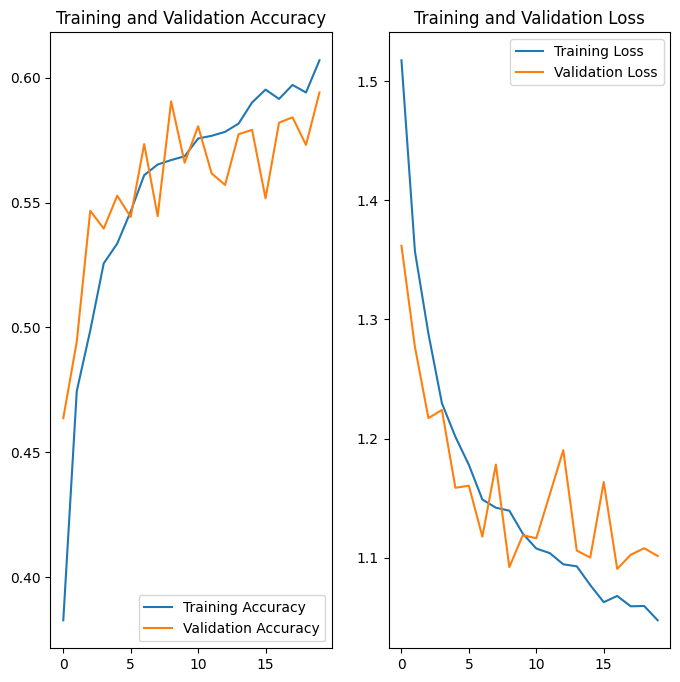

In [ ]:
# Extraer la precisión y pérdida de entrenamiento y validación del historial
acc = history_dnn.history['accuracy']  # Precisión de entrenamiento
val_acc = history_dnn.history['val_accuracy']  # Precisión de validación

loss = history_dnn.history['loss']  # Pérdida de entrenamiento
val_loss = history_dnn.history['val_loss']  # Pérdida de validación

epochs_range = range(20)  # Cantidad de epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Durante el entrenamiento puede verse una diferencia considerable entre la pérdida y la precisión, lo que indica un sobreajuste. Esto quiere decir que el modelo está aprendiendo del ruido de los datos de entrenamiento y tiene problemas para generalizar a datos nuevos.

#### 3.1.6. Evaluar el modelo en conjunto de test

In [ ]:
# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model_dnn.evaluate(test_generator)
print('Test accuracy:', f'{test_acc:.4}')


94/94 [==============================] - 2s 25ms/step - loss: 1.1044 - accuracy: 0.5757
Test accuracy: 0.5757


El resultado de la evaluación en el conjunto de testing es deficiente, mostrando una precisión de 0.57.

#### 3.1.7. Realizar predicciones

1/1 [==============================] - 0s 17ms/step


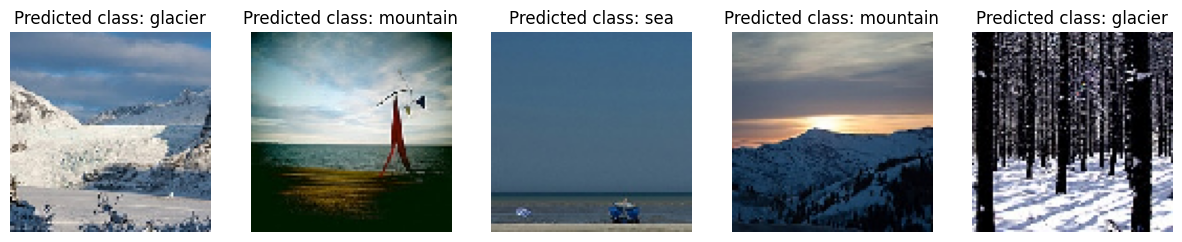

In [ ]:
# Obtener las rutas de los directorios de imágenes de predicción
prediction_dir = os.path.join(dataset_dir, "seg_pred", "seg_pred")
prediction_image_paths = [os.path.join(prediction_dir, filename) for filename in os.listdir(prediction_dir)]

# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Elegir 5 imágenes aleatoriamente para la predicción
random_image_paths = random.sample(prediction_image_paths, 5)

plt.figure(figsize=(15, 10))
for i, random_image_path in enumerate(random_image_paths):
    # Cargar y preprocesar la imagen
    img = load_img(random_image_path, target_size=(96, 96))
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Crear un batch

    # Hacer las predicciones
    predictions = model_dnn.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index]

    # Mostrar la imagen y la predicción
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted class: {predicted_class}')

plt.show()

Puede verse cómo solo predice correctamente algunas de las imágenes.

### 3.2. Redes convolucionales

El modelo de red convolucional (CNN) utilizado tiene una arquitectura compuesta por varias capas.

Comienza con una capa Convolucional 2D con 32 filtros y una función de activación ReLU, seguida de una capa de MaxPooling2D para reducir la dimensionalidad.

Posteriormente, se repiten dos veces este patrón: una capa Conv2D con más filtros (64 y luego 128) y otra capa de MaxPooling2D.

Después de estas capas convolucionales, se agrega una capa de aplanamiento (Flatten) para convertir las características en un vector unidimensional.

Luego, hay una capa densa con 512 neuronas y activación ReLU para realizar la clasificación basada en las características extraídas por las capas convolucionales.

Para evitar el sobreajuste, se aplica una capa de Dropout con una tasa de dropout del 50%.

Finalmente, la capa de salida tiene un número de neuronas igual al número de clases (6 en este caso) y utiliza la función de activación softmax para la clasificación multiclase.

#### 3.2.1. Definir el modelo

In [ ]:
# Función para construir un modelo de clasificación usando redes convolucionales
def build_classification_model_cnn(input_shape, num_classes):
    # Crea un modelo secuencial
    model = Sequential([
        # Capa convolucional con 32 filtros y función de activación ReLU
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        # Capa de max pooling para reducción de dimensionalidad
        MaxPooling2D((2, 2)),
        # Capa convolucional con 64 filtros y función de activación ReLU
        Conv2D(64, (3, 3), activation='relu'),
        # Capa de max pooling para reducción de dimensionalidad
        MaxPooling2D((2, 2)),
        # Capa convolucional con 128 filtros y función de activación ReLU
        Conv2D(128, (3, 3), activation='relu'),
        # Capa de max pooling para reducción de dimensionalidad
        MaxPooling2D((2, 2)),
        # Aplana los mapas de características para la capa densa
        Flatten(),
        # Capa densa con 512 neuronas y función de activación ReLU
        Dense(512, activation='relu'),
        # Capa de dropout para regularización
        Dropout(0.5),
        # Capa de salida con activación softmax para clasificación multiclase
        Dense(num_classes, activation='softmax')
    ])
    return model

# Tamaño de entrada de las imágenes y número de clases
input_shape = (96, 96, 3)  # Tamaño de entrada de las imágenes
num_classes = 6  # Número de clases (etiquetas)


#### 3.2.2. Connstruir y compilar el modelo

In [ ]:
# Construir el modelo CNN
model_cnn = build_classification_model_cnn(input_shape, num_classes)

# Compilar el modelo
model_cnn.compile(
    optimizer='adam',  # Optimizador Adam
    loss='categorical_crossentropy',  # Función de pérdida categorical_crossentropy
    metrics=['accuracy']  # Métrica de evaluación: precisión (accuracy)
)

#### 3.2.3. Mostrar el resumen del modelo

In [ ]:
# Mostrar un resumen del modelo CNN
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 10, 128)      

#### 3.2.4. Entrenar el modelo

In [14]:
# Número de épocas
EPOCHS = 20

In [ ]:
# Entrenar el modelo CNN
history_cnn = model_cnn.fit(
    train_generator,  # Generador de datos de entrenamiento
    validation_data=validation_generator,  # Generador de datos de validación
    epochs=EPOCHS,  # Número de épocas de entrenamiento
    verbose=1  # Modo verbose (imprime información durante el entrenamiento)
)

Epoch 1/20
351/351 [==============================] - 47s 125ms/step - loss: 1.0992 - accuracy: 0.5625 - val_loss: 0.9020 - val_accuracy: 0.6523
Epoch 2/20
351/351 [==============================] - 41s 117ms/step - loss: 0.8270 - accuracy: 0.6933 - val_loss: 0.7030 - val_accuracy: 0.7414
Epoch 3/20
351/351 [==============================] - 40s 115ms/step - loss: 0.6897 - accuracy: 0.7443 - val_loss: 0.6217 - val_accuracy: 0.7707
Epoch 4/20
351/351 [==============================] - 41s 117ms/step - loss: 0.6103 - accuracy: 0.7784 - val_loss: 0.5607 - val_accuracy: 0.8071
Epoch 5/20
351/351 [==============================] - 43s 122ms/step - loss: 0.5598 - accuracy: 0.7983 - val_loss: 0.5138 - val_accuracy: 0.8195
Epoch 6/20
351/351 [==============================] - 44s 124ms/step - loss: 0.5169 - accuracy: 0.8148 - val_loss: 0.5524 - val_accuracy: 0.8060
Epoch 7/20
351/351 [==============================] - 41s 116ms/step - loss: 0.4851 - accuracy: 0.8302 - val_loss: 0.4923 - val_ac

#### 3.2.5. Visualizar Accuracy y Loss de entrenamiento y validación

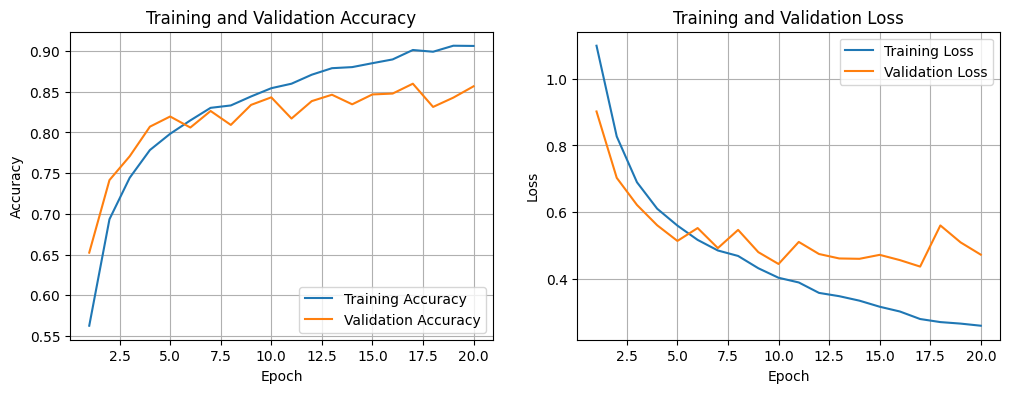

In [ ]:
# Plot accuracy and loss
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()


Nuevamente pouede observarse una discrepancia entre la pérdida y la precisión de entrenamiento y validación, siendo mayor el error en la validación y menor la precisión.  Esto indica que nuevamente, el modelo está sobreajustando.

#### 3.2.6. Evaluar en el conjunto de prueba

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_cnn.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94/94 [==============================] - 3s 28ms/step - loss: 0.4877 - accuracy: 0.8540
Test Loss: 0.4877055585384369
Test Accuracy: 0.8539999723434448


A pesar del sobreajuste, la red convolucional muestra un rendimiento mucho mejor que la red densa, siendo su precisión de ~0.85

#### 3.2.7. Realizar predicciones

In [17]:
# Define IMAGE_HEIGHT and IMAGE_WIDTH
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

1/1 [==============================] - 0s 30ms/step


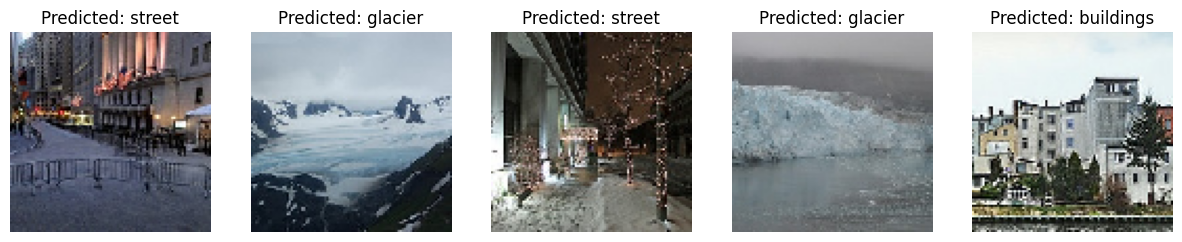

In [ ]:
# Get some sample images from the prediction set
prediction_image_paths = random.sample(test_generator.filepaths, 5)

# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Make predictions on the sample images
predictions = []
for image_path in prediction_image_paths:
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    prediction = model_cnn.predict(img_array)
    predictions.append(prediction.argmax())

# Display the sample images with their predicted labels
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(prediction_image_paths):
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predictions[i]]}")
    plt.axis("off")
plt.show()


Se corrobora que la red convolucional predice correctamente mayor cantidad de imágenes que la densa.

### 3.3 - Redes neuronales con bloques ResNet

Se modificará el modelo para incluir bloques de ResNet según la siguiente estructura simplificada

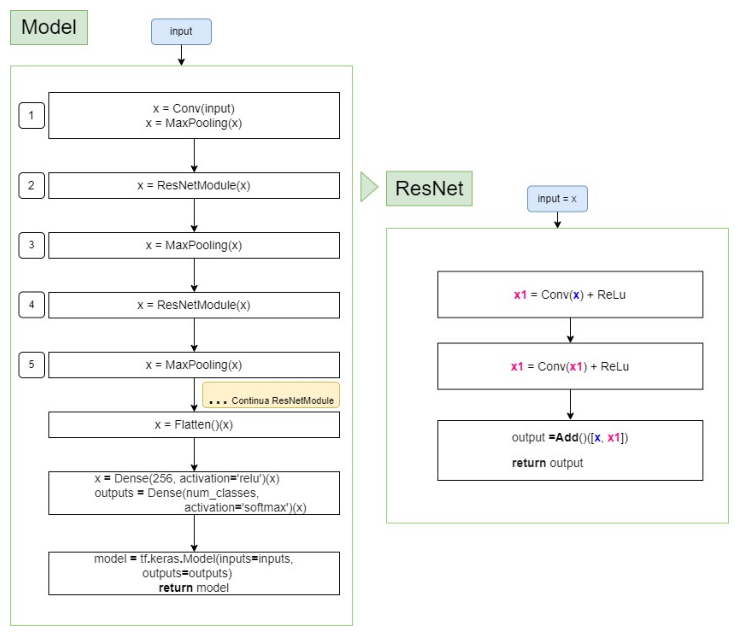

In [4]:
from PIL import Image

# Cargar la imagen
model_structure_image_path = 'Redes_cnn_con_bloques_ResNet.jpg'
image = Image.open(model_structure_image_path)

# Crear una figura con un tamaño específico
plt.figure(figsize=(15, 8))

# Mostrar la imagen con el nuevo tamaño
plt.imshow(image)
plt.axis('off')
plt.show()


La red ResNet, que significa Redes Residuales, es una arquitectura profunda de redes neuronales convolucionales (CNN) que aborda el problema de la degradación del rendimiento en redes profundas.

Introduce conexiones de atajos que saltan una o más capas, lo que facilita el flujo del gradiente durante el entrenamiento y permite construir redes más profundas.

El modelo ResNet utilizado, en este caso, comienza con una capa convolucional inicial de 7x7 seguida de una capa de MaxPooling.

Luego, se aplican cinco módulos ResNet, cada uno con capas convolucionales y conexiones de atajos.

Después de cada módulo, se usa una capa de MaxPooling para reducir la dimensionalidad.

Las características se aplanan y se pasan a través de capas densas con dropout para la regularización, seguidas de una capa de salida con activación softmax para la clasificación multiclase.

#### 3.3.1. Se define el bloque ResNet

In [7]:
# Define el módulo ResNet
def resnet_module(x, filters):
    # Capa convolucional 3x3
    conv = Conv2D(filters=filters[0], kernel_size=(3, 3), activation='relu', padding='same')(x)

    # Capa convolucional 3x3
    conv = Conv2D(filters=filters[1], kernel_size=(3, 3), activation='relu', padding='same')(conv)

    # Capa convolucional 1x1
    x = Conv2D(filters=filters[1], kernel_size=(1, 1), activation='relu', padding='same')(x)

    # Suma de la entrada y la salida
    output = Add()([x, conv])

    return output

#### 3.3.2. Se define una función para construir el modelo

In [8]:
# Define el modelo ResNet
def cnn_ResNet(input_shape, num_classes):
    # Capa de entrada
    inputs = Input(shape=input_shape)

    # Capa convolucional inicial 7x7
    x = Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Primer módulo ResNet
    x = resnet_module(x, [64, 32])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Segundo módulo ResNet
    x = resnet_module(x, [32, 160])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Tercer módulo ResNet
    x = resnet_module(x, [160, 128])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Tercer módulo ResNet
    x = resnet_module(x, [128, 192])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Tercer módulo ResNet
    x = resnet_module(x, [192, 96])
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Capa de aplanamiento y capas densas
    x = Flatten()(x)
    x = Dropout(0.3)(x)  # Dropout con tasa de 0.3 para evitar el sobreajuste
    x = Dense(1152, activation='relu')(x)  # Capa densa intermedia con 1152 neuronas
    x = BatchNormalization()(x)  # Normalización de lotes para acelerar el entrenamiento
    x = Dropout(0.5)(x)  # Dropout con tasa de 0.5 para evitar el sobreajuste

    # Capa de salida
    outputs = Dense(num_classes, activation='softmax')(x)  # Capa de salida con activación softmax para clasificación multiclase

    # Construye el modelo
    model = Model(inputs=inputs, outputs=outputs)
    return model

#### 3.3.3. Se inicializa el modelo

In [9]:
# Define la forma de entrada
input_shape = (96, 96, 3)  # Tamaño de las imágenes de entrada (altura, anchura, canales)
num_classes = 6  # Número de clases en el conjunto de datos

# Crear el modelo ResNet
model_resnet = cnn_ResNet(input_shape, num_classes)  # Crea el modelo ResNet utilizando la función cnn_ResNet

#### 3.3.4. Se compila el modelo

In [10]:
# Compilar el modelo ResNet
model_resnet.compile(
    optimizer='adam',  # Optimizador Adam para ajustar los pesos de la red
    loss='categorical_crossentropy',  # Función de pérdida para problemas de clasificación multiclase
    metrics=['accuracy']  # Métrica de evaluación para monitorear durante el entrenamiento
)

In [11]:
# Imprimir el resumen del modelo
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 24, 64)           36928     ['max_pooling2d[0][0]']   

#### 3.3.5. Se entrena el modelo

In [12]:
# Entrenar el modelo ResNet
history = model_resnet.fit(
    train_generator,  # Generador de datos de entrenamiento
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de pasos por época para el conjunto de entrenamiento
    validation_data=validation_generator,  # Generador de datos de validación
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Número de pasos por época para el conjunto de validación
    epochs=20  # Número de épocas de entrenamiento
)

Epoch 1/20
350/350 [==============================] - 63s 142ms/step - loss: 1.3210 - accuracy: 0.4552 - val_loss: 1.6037 - val_accuracy: 0.3732
Epoch 2/20
350/350 [==============================] - 43s 123ms/step - loss: 1.0233 - accuracy: 0.5995 - val_loss: 0.8712 - val_accuracy: 0.6717
Epoch 3/20
350/350 [==============================] - 43s 124ms/step - loss: 0.9080 - accuracy: 0.6561 - val_loss: 0.8445 - val_accuracy: 0.6972
Epoch 4/20
350/350 [==============================] - 46s 131ms/step - loss: 0.8517 - accuracy: 0.6790 - val_loss: 0.9681 - val_accuracy: 0.6695
Epoch 5/20
350/350 [==============================] - 43s 122ms/step - loss: 0.7977 - accuracy: 0.7073 - val_loss: 0.8809 - val_accuracy: 0.6954
Epoch 6/20
350/350 [==============================] - 45s 128ms/step - loss: 0.7366 - accuracy: 0.7302 - val_loss: 1.0014 - val_accuracy: 0.6710
Epoch 7/20
350/350 [==============================] - 44s 125ms/step - loss: 0.7106 - accuracy: 0.7426 - val_loss: 0.6549 - val_ac

#### 3.3.6. Visualizar resultados de entrenamiento

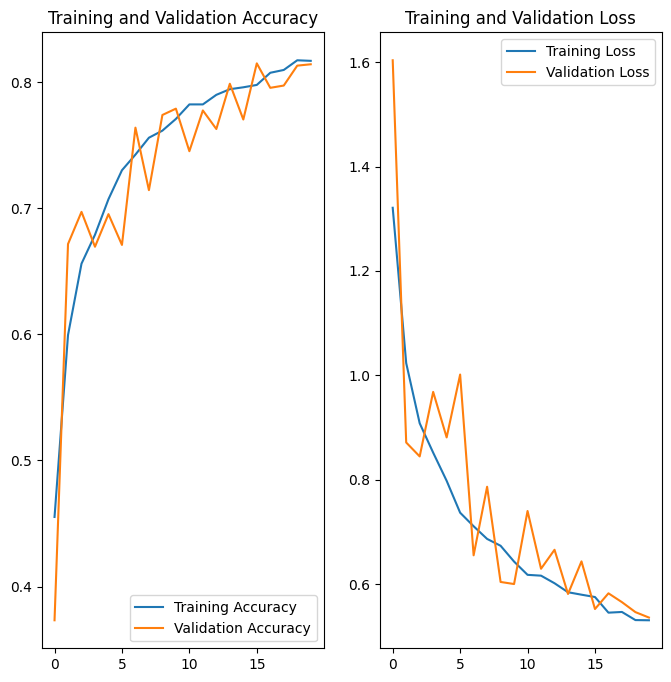

In [15]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc_resnet = history.history['accuracy']
val_acc_resnet = history.history['val_accuracy']

loss_resnet = history.history['loss']
val_loss_resnet = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_resnet, label='Training Accuracy')
plt.plot(epochs_range, val_acc_resnet, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_resnet, label='Training Loss')
plt.plot(epochs_range, val_loss_resnet, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.3.7. Realizar predicciones

In [18]:
# Directorio de las imágenes de prueba
TEST_DATA_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Obtener la lista de rutas de las imágenes de prueba
test_image_paths = list(TEST_DATA_DIRECTORY.glob("*.jpg"))

# Lista para almacenar las imágenes cargadas
test_images = []
for image_path in test_image_paths:
    # Cargar la imagen y redimensionarla según sea necesario
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    # Convertir la imagen a un array numpy
    img_array = img_to_array(img)
    # Agregar la imagen al conjunto de datos
    test_images.append(img_array)

# Convertir la lista de imágenes a un array numpy
test_images = np.array(test_images)

In [19]:
# Evaluar el modelo en el conjunto de validación
val_predictions_resnet = model_resnet.predict(test_images)
# Obtener clases estimadas (convertir probabilidades a clases)
predicted_classes_resnet = np.argmax(val_predictions_resnet, axis=1)# Evaluar el modelo en el conjunto de validación

229/229 [==============================] - 3s 13ms/step


In [20]:
# Evaluate the model on the test set
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_generator)

print("Test Loss:", f'{test_loss_resnet:.4}')
print("Test Accuracy:", f'{test_accuracy_resnet:.4}')

94/94 [==============================] - 3s 33ms/step - loss: 0.5298 - accuracy: 0.8233
Test Loss: 0.5298
Test Accuracy: 0.8233


El modelo ResNet muestra un rendimiento inferior a la red convolucional.

#### 3.3.8. Se visualizan ejemplos de imágenes con sus correspondientes predicciones

1/1 [==============================] - 0s 18ms/step


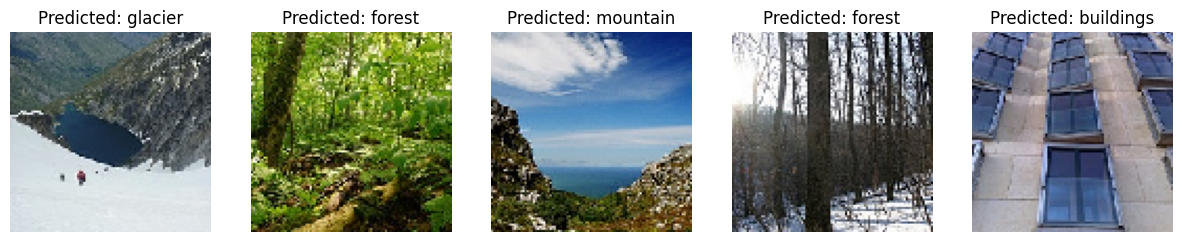

In [22]:
# Get some sample images from the prediction set
prediction_image_paths = random.sample(test_generator.filepaths, 5)

# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Make predictions on the sample images
predictions = []
for image_path in prediction_image_paths:
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    prediction = model_resnet.predict(img_array)
    predictions.append(prediction.argmax())

# Display the sample images with their predicted labels
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(prediction_image_paths):
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predictions[i]]}")
    plt.axis("off")
plt.show()

### 3.4. Transfer Learning

#### 3.4.1. Configuración del Modelo



##### 3.4.1.1. Backbone
Para el backbone hemos escogido MobileNetV2 que es una arquitectura de red neuronal convolucional liviana diseñada para aplicaciones de visión integradas y móviles. Otras razones son:

  * **Eficiencia**: MobileNetV2 es conocido por su eficiencia tanto en términos de tamaño del modelo como de recursos computacionales. Logra un buen equilibrio entre el tamaño y la precisión del modelo, lo que lo hace adecuado para su implementación en dispositivos con recursos limitados.

  * **Preentrenado con ImageNet**: MobileNetV2 está preentrenado con el conjunto de datos de ImageNet, que contiene una gran cantidad de imágenes diversas en varias categorías. Este entrenamiento previo ayuda al modelo a aprender características ricas que son transferibles a otras tareas, incluida la clasificación de escenas naturales en este caso.

  * **Convoluciones separables en profundidad**: MobileNetV2 utiliza convoluciones separables en profundidad, que separan las operaciones espaciales y de canal, lo que reduce la complejidad computacional y mantiene el poder expresivo. Esto lo hace eficiente para dispositivos móviles e integrados.


In [ ]:
# Elegir el modelo preentrenado base (backbone)
base_model = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),  # Tamaño de entrada de las imágenes
                                               include_top=False,  # No incluir las capas densas finales
                                               weights='imagenet')  # Inicializar pesos con ImageNet preentrenado

# Congelar las capas del modelo preentrenado
base_model.trainable = False  # Congelar el modelo para que los pesos no se actualicen durante el entrenamiento

9406464/9406464 [==============================] - 0s 0us/step



##### 3.4.1.2. Head

1. Capa 2D de agrupación promedio global:

    * La capa Global Average Pooling 2D reduce las dimensiones espaciales de los mapas de características de la red troncal a un único vector tomando el promedio de cada canal del mapa de características.
    * Esto ayuda a reducir la cantidad de parámetros en el modelo y lo hace menos propenso a sobreajustarse.
    * Global Average Pooling retiene la información espacial esencial al tiempo que hace que el modelo sea más robusto a las traducciones espaciales o distorsiones en las imágenes de entrada.

2. Capa Densa (Capa Totalmente Conectada):
    * La capa Densa se agrega para introducir no linealidad y aumentar la capacidad del modelo para capturar patrones complejos en los datos.
    * Consta de 256 neuronas con función de activación ReLU.
    * Se elige ReLU como función de activación porque ayuda a mitigar el problema del gradiente evanescente y acelera la convergencia del proceso de entrenamiento.
    * Se eligen 256 neuronas como un compromiso entre la complejidad y el rendimiento del modelo.

3. Capa de Dropout:
    * El Dropout es una técnica de regularización que elimina aleatoriamente una fracción de neuronas durante el entrenamiento para evitar el sobreajuste.
    * En este caso, se aplica un Dropout del 50 %, lo que significa que la mitad de las neuronas se eliminarán aleatoriamente durante cada iteración de entrenamiento.
    * El Dropout ayuda a mejorar la capacidad de generalización del modelo al obligarlo a aprender características más sólidas.

4. Capa densa de salida:
    * La capa de salida consta de 6 neuronas, correspondientes a las 6 clases (building, forest, glacier, mountain, sea, street).
    * La función de activación utilizada es softmax, que convierte las puntuaciones crudas, producidas por la capa anterior, en probabilidades.
    * Softmax garantiza que las probabilidades de salida sumen 1, lo que lo hace adecuado para tareas de clasificación de clases múltiples.
    * El modelo predice la clase con mayor probabilidad como resultado final.

El Global Average Pooling reduce la dimensionalidad de los mapas de características al tiempo que retiene información importante, lo que hace que el modelo sea computacionalmente eficiente.

Agregar una capa densa con activación ReLU introduce no linealidad y permite que el modelo aprenda patrones complejos en los datos.

El Dropout ayuda a prevenir el sobreajuste al regularizar el modelo durante el entrenamiento.

La capa densa de salida con activación softmax produce probabilidades para cada clase, lo que permite que el modelo realice predicciones precisas de múltiples clases.



In [ ]:
# Añadir nuevas capas encima del modelo preentrenado (head)
model = tf.keras.Sequential([
    base_model,  # Agrega el modelo preentrenado MobileNetV2 como base
    tf.keras.layers.GlobalAveragePooling2D(),  # Capa de pooling global para reducir la dimensionalidad
    tf.keras.layers.Dense(256, activation='relu'),  # Capa densa con 256 neuronas y activación ReLU
    tf.keras.layers.Dropout(0.5),  # Capa de dropout para regularización
    tf.keras.layers.Dense(6, activation='softmax')  # Capa densa de salida con 6 neuronas y activación softmax
])

# Compilar el modelo
model.compile(
    optimizer='adam',  # Optimizador Adam para ajustar los pesos
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
    metrics=['accuracy']  # Métrica de evaluación durante el entrenamiento
)

# Mostrar resumen del modelo
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 256)               327936    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 2587462 (9.87 MB)
Trainable params: 3294

#### 3.4.2 Entrenamiento del modelo

Ahora, entrenaremos el modelo usando los datos de entrenamiento y lo validaremos usando los datos de validación.

In [ ]:
# Entrenar el modelo (sólo el head se entrenará porque al backbone lo hemos congelado)
history = model.fit(
    train_generator,  # Set de entrenamiento
    steps_per_epoch = train_generator.samples/train_generator.batch_size,  # Definir los steps por epoch
    epochs=20,  # Cantidad de epochs de entrenamiento
    validation_data=validation_generator,  # Set de validación
    validation_steps=validation_generator.samples/validation_generator.batch_size  # Cantidad de steps de valicación
)

Epoch 1/10
350/350 [==============================] - 53s 141ms/step - loss: 0.4790 - accuracy: 0.8266 - val_loss: 0.3230 - val_accuracy: 0.8802
Epoch 2/10
350/350 [==============================] - 43s 123ms/step - loss: 0.3588 - accuracy: 0.8674 - val_loss: 0.3137 - val_accuracy: 0.8887
Epoch 3/10
350/350 [==============================] - 43s 122ms/step - loss: 0.3243 - accuracy: 0.8810 - val_loss: 0.3344 - val_accuracy: 0.8816
Epoch 4/10
350/350 [==============================] - 41s 117ms/step - loss: 0.3142 - accuracy: 0.8849 - val_loss: 0.3022 - val_accuracy: 0.8902
Epoch 5/10
350/350 [==============================] - 43s 122ms/step - loss: 0.2930 - accuracy: 0.8924 - val_loss: 0.2935 - val_accuracy: 0.8934
Epoch 6/10
350/350 [==============================] - 42s 118ms/step - loss: 0.2879 - accuracy: 0.8923 - val_loss: 0.3095 - val_accuracy: 0.8898
Epoch 7/10
350/350 [==============================] - 41s 118ms/step - loss: 0.2870 - accuracy: 0.8929 - val_loss: 0.3056 - val_ac

#### 3.4.3. Visualización de resultados
Podemos visualizar la precisión y pérdida del entrenamiento y la validación para comprender el rendimiento del modelo.

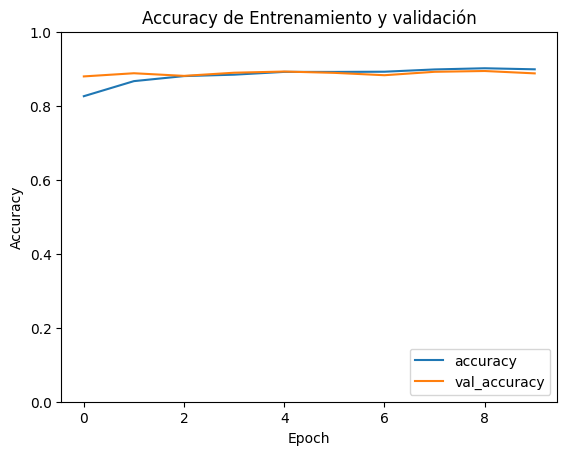

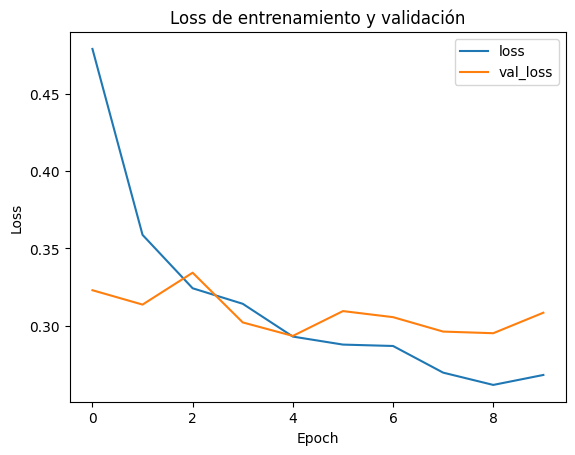

In [ ]:
# Graficar el accuracy de entrenamiento y validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy de Entrenamiento y validación')
plt.show()

# Graficar el accuracy de entrenamiento y validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss de entrenamiento y validación')
plt.show()


#### 3.4.4. Evaluar el modelo en el conjunto de testing

In [ ]:
# Evaluar el modelo en el set de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', f'{test_acc:.4}')

94/94 - 6s - loss: 0.2642 - accuracy: 0.8983 - 6s/epoch - 63ms/step

Test accuracy: 0.8983


Puede observarse una precisión de aproximadamente 0.9 en la red de Transfer Learning con backbone de MobileNetV2, superior todas las anteriores.


#### 3.4.5. Hacer predicciones con el modelo

1/1 [==============================] - 0s 21ms/step


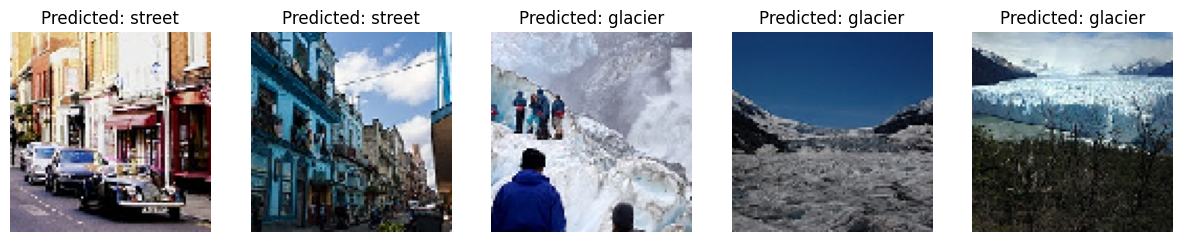

In [ ]:
# Get some sample images from the prediction set
prediction_image_paths = random.sample(test_generator.filepaths, 5)

# Obtener las etiquetas de las clases
class_labels = list(train_generator.class_indices.keys())

# Make predictions on the sample images
predictions = []
for image_path in prediction_image_paths:
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    prediction = model.predict(img_array)
    predictions.append(prediction.argmax())

# Display the sample images with their predicted labels
plt.figure(figsize=(15, 10))
for i, image_path in enumerate(prediction_image_paths):
    img = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predictions[i]]}")
    plt.axis("off")
plt.show()

## 4. Comparación

Los resultados los modelos fueron los siguientes.  


1. Red Neuronal Densa (Fully Connected)
    * Test Accuracy: 0.58
2. Red Neuronal Convolucional (CNN)
    * Test Accuracy: 0.85
3. Red Neuronal Recidual (ResNet)
    * Test Accuracy: 0.79
4. Red Neuronal con Transferencia (Transfer Learning)
    * Test Accuracy: 0.9
